### Задание для курсового проекта
Метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Примечание: Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):

Файл должен содержать заголовки и комментарии
Повторяющиеся операции лучше оформлять в виде функций
Не делать вывод большого количества строк таблиц (5-10 достаточно)
По возможности добавлять графики, описывающие данные (около 3-5)
Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
Весь проект должен быть в одном скрипте (файл ipynb).
При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию, но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
Проект должен полностью отрабатывать за разумное время (не больше 10 минут), поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров.
Допускается применение любых моделей машинного обучения из библиотеки sklearn.

### Готовим данные

In [1]:
import numpy as np
import pandas as pd
import random

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set_palette("pink")

### Функции для графиков

In [4]:
def evaluate_preds(train_true_values, train_pred_values, val_true_values, val_pred_values):
    """
    Функция для оценки работы модели
    """
    print("Тренировочный R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Тестовый R2:\t" + str(round(r2(val_true_values, val_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values, cmap='pink')
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Тренировочный')
    
    plt.subplot(122)
    sns.scatterplot(x=val_pred_values, y=val_true_values, cmap='pink')
    plt.xlabel('Предсказанные данные')
    plt.ylabel('Настоящие данные')
    plt.title('Тестовый')
    plt.show()

In [5]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

In [6]:
train = pd.read_csv(TRAIN_DATASET_PATH)
display(train.head())
print(train.shape)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


(10000, 20)


In [7]:
test = pd.read_csv(TEST_DATASET_PATH)
print(test.shape)

(5000, 19)


### Приведение типов

In [8]:
train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [9]:
train['Id'] = train['Id'].astype(str)
#train['DistrictId'] = train['DistrictId'].astype(str)
#test['DistrictId'] = test['DistrictId'].astype(str)
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [10]:
train = train.set_index('Id')
test = test.set_index('Id')

In [11]:
train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


#### Изучаем данные, строим графики

In [12]:
price_round = len(np.unique(np.array([round(x, -4) for x in train['Price'].unique()])))
price_round_2 = len(np.unique(np.array([round(x, -3) for x in train['Price'].unique()])))
price_round, price_round_2

(58, 532)

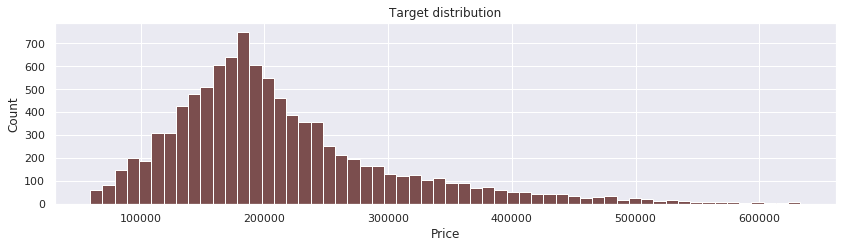

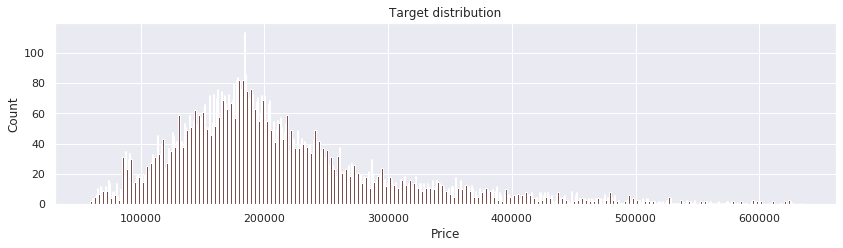

In [13]:
grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.1)
fig, ax = plt.subplots(figsize=(14, 7))

plt.subplot(grid[0, 0:])
train['Price'].hist(bins=price_round)
plt.ylabel('Count')
plt.xlabel('Price')
plt.title('Target distribution')
plt.show()
fig, ax = plt.subplots(figsize=(14, 7))

plt.subplot(grid[1, 0:])
train['Price'].hist(bins=price_round_2)
plt.ylabel('Count')
plt.xlabel('Price')
plt.title('Target distribution')
plt.show()

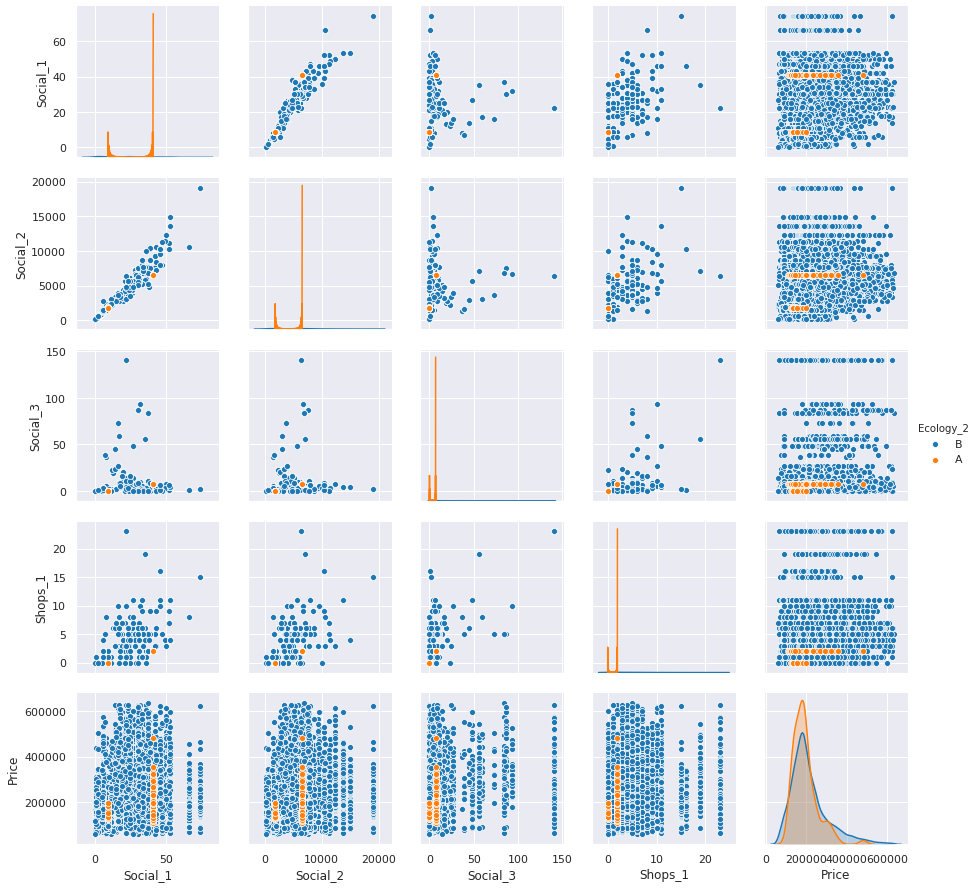

In [14]:
sns.set_palette("tab10")
sns.pairplot(train, vars=['Social_1', 'Social_2', 'Social_3', 'Shops_1',  'Price'], hue='Ecology_2', height=2.5);

In [15]:
train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [16]:
cat_colnames = train.select_dtypes(include='object').columns.tolist()
cat_colnames

['Ecology_2', 'Ecology_3', 'Shops_2']

In [17]:
for cat_colname in cat_colnames[1:]:
    print(str(cat_colname) + '\n\n' + str(train[cat_colname].value_counts()) + '\n' + '*' * 20 + '\n')

Ecology_3

B    9725
A     275
Name: Ecology_3, dtype: int64
********************

Shops_2

B    9175
A     825
Name: Shops_2, dtype: int64
********************



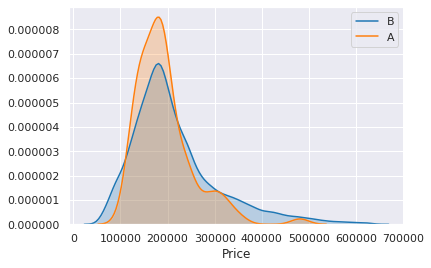

In [18]:
sns.kdeplot(train.Price[train.Ecology_2=='B'],
label='B', shade=True)
sns.kdeplot(train.Price[train.Ecology_2=='A'],
label='A', shade=True)
plt.xlabel('Price');

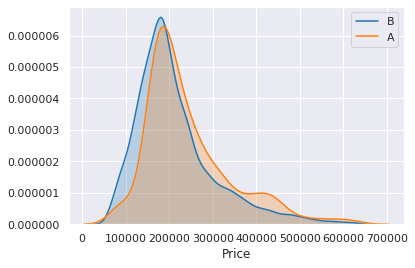

In [19]:
sns.kdeplot(train.Price[train.Ecology_3=='B'],
label='B', shade=True)
sns.kdeplot(train.Price[train.Ecology_3=='A'],
label='A', shade=True)
plt.xlabel('Price');

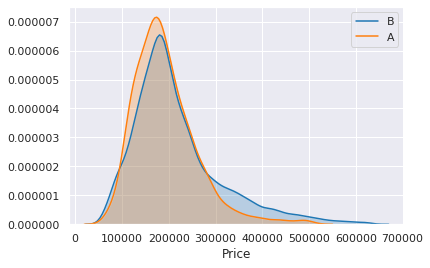

In [20]:
sns.kdeplot(train.Price[train.Shops_2=='B'],
label='B', shade=True)
sns.kdeplot(train.Price[train.Shops_2=='A'],
label='A', shade=True)
plt.xlabel('Price');

### Выбросы и нули


##### Square, LifeSquare, KitchenSquare

In [21]:
train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


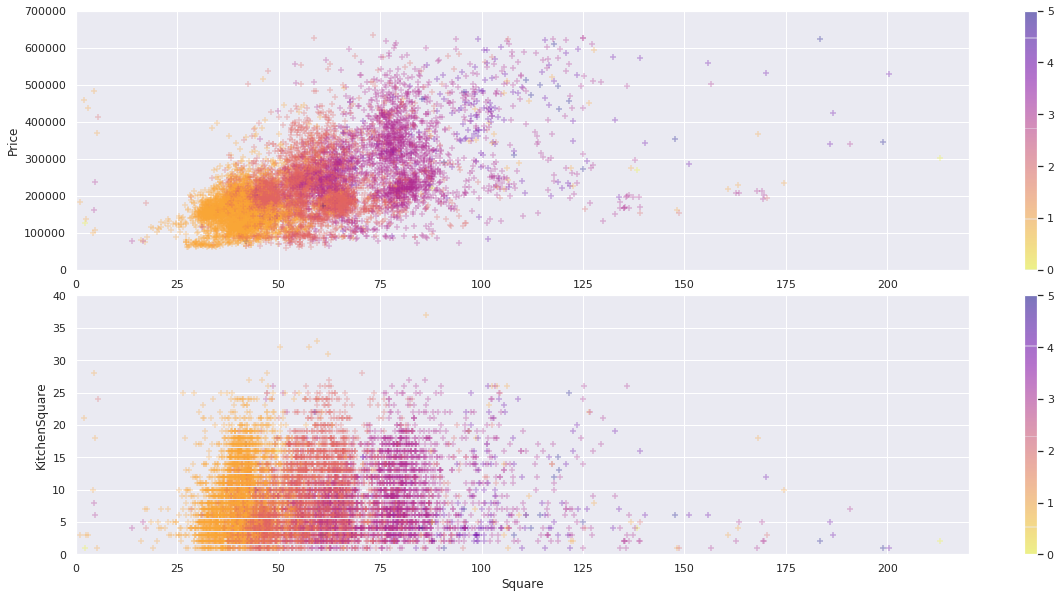

In [22]:
grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.1)
fig, ax = plt.subplots(figsize=(20, 10))

plt.subplot(grid[0, 0:])
plt.scatter(train.Square, train.Price, marker='+',c=train.Rooms
            , alpha=0.3,
            cmap='plasma_r')
plt.xlabel("Square")
plt.ylabel("Price")
plt.axis([0, 220, 0, 700000]);
plt.colorbar()
plt.clim(0, 5)

plt.subplot(grid[1, 0:])
plt.scatter(train.Square,train.Floor, marker='+',c=train.Rooms
            , alpha=0.3,
            cmap='plasma_r')
plt.xlabel("Square")
plt.ylabel("KitchenSquare")
plt.axis([0, 220, 0, 40]);
plt.colorbar()
plt.clim(0, 5);


In [23]:
train.loc[train['LifeSquare'] > train['Square'], ('Square', 'LifeSquare')]


,Square,LifeSquare
Id,,
8054,42.530043,43.967759
10521,104.211396,106.340403
2301,61.400054,65.224603
8753,85.952306,89.803753
9870,51.831473,53.491301
...,...,...
41,59.015896,59.439082
12918,51.440463,53.134243
2737,123.430072,125.806981


In [24]:
def square_life(data_sq):
    """
    Меняем местами жилую площадь и общую площадь,
    там где жилая площадь указана больше общей.
    """
    list_id = list(data_sq.loc[data_sq['LifeSquare'] > data_sq['Square'], ('Square', 'LifeSquare')].index)
    
    data_sq['to_copy'] = data_sq['Square']
    for x in list_id:
        data_sq.loc[x,'Square'] = data_sq.loc[x, 'LifeSquare']
        data_sq.loc[x, 'LifeSquare'] = data_sq.loc[x, 'to_copy']
    del data_sq['to_copy']
    

In [25]:
square_life(train)
square_life(test)

In [26]:
train.isnull().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [27]:
train['LifeSquare'].median()

32.76010840286361

In [28]:
def life_null(data_l):
    square_med_diff = (data_l.loc[data_l['LifeSquare'].notnull(), 'Square']
                       - data_l.loc[data_l['LifeSquare'].notnull(), 'LifeSquare']
                       - data_l.loc[data_l['LifeSquare'].notnull(), 'KitchenSquare']).quantile(0.1)
    
    data_l.loc[data_l['LifeSquare'].isnull(), 'LifeSquare'] = (
        data_l.loc[data_l['LifeSquare'].isnull(), 'Square']
        - data_l.loc[data_l['LifeSquare'].isnull(), 'KitchenSquare']
        - square_med_diff
    )


In [29]:
life_null(train)
life_null(test)

In [30]:
train['LifeSquare'].median()

36.79304090323445

In [32]:
train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,57.223484,40.713992,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,43.587592,0.839512,77.309420,22.111396,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,0.000000,2.377248,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.866858,25.470423,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.633651,36.793041,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,66.004634,49.466936,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,7480.592129,638.163193,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


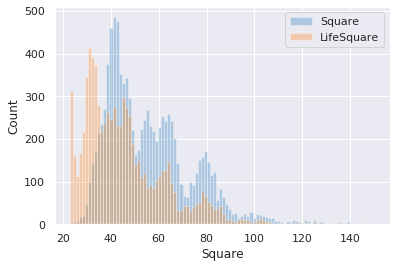

In [33]:
plt.hist(train['Square'],bins=100, range=(23, 150),label='Square', alpha=0.3)
plt.hist(train['LifeSquare'],bins=100, range=(23, 150),label='LifeSquare', alpha=0.3)
plt.ylabel('Count')
plt.xlabel('Square')
plt.legend();


In [34]:
train.loc[train['Square'] > train['Square'].quantile(.9999)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
16550,27,3.0,7480.592129,81.694417,1.0,9,17.0,2016,0.017647,B,B,2,469,0,NaN,0,0,B,217357.492366


In [35]:
train.loc[train['Square'] > train['Square'].quantile(.9999), 'Square'] = train.loc[train['Square'] > train['Square'].quantile(.9999), 'LifeSquare'] + train.loc[train['Square'] > train['Square'].quantile(.9999), 'KitchenSquare']

In [36]:
train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.483694,40.713992,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.565543,22.111396,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,0.000000,2.377248,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.866858,25.470423,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.633651,36.793041,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,66.004634,49.466936,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,638.163193,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [37]:
def kitchen(data_df):
    data_df.loc[(data_df['KitchenSquare'] > 30), 'KitchenSquare'] = data_df.loc[(data_df['KitchenSquare'] > 30), 'Square'] 
    data_df.loc[(data_df['KitchenSquare'] < 3), 'KitchenSquare'] = 3 
    

In [38]:
kitchen(train)
kitchen(test)

In [39]:
train['KitchenSquare'].describe()

count    10000.000000
mean         6.642164
std          5.612662
min          3.000000
25%          3.000000
50%          6.000000
75%          9.000000
max        186.692602
Name: KitchenSquare, dtype: float64

#### Rooms

In [40]:
train['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [41]:
train.loc[train['Rooms'] > 7]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792
8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704
14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863


In [42]:
train.loc[(train['Square'] < 55.0) & (train['Square'] > 40.0), "Rooms"].unique()

array([ 2.,  1.,  3., 19.,  0.,  5.,  4.])

In [43]:
test['Rooms'].value_counts()

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
0.0        2
6.0        2
17.0       1
Name: Rooms, dtype: int64

In [44]:
test.loc[(test['Rooms'] > 8) | (test['Rooms'] < 1)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
3343,58,0.0,116.824201,113.692424,3.0,3,3.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
10729,27,0.0,76.345154,42.820796,12.0,14,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B
1435,111,17.0,52.866107,32.528342,8.0,15,17.0,1987,0.093443,B,B,23,4635,5,3300.0,2,4,B


In [45]:
test.loc[(test['Square'] < 55.0) & (test['Square'] > 45.0), "Rooms"].unique()

array([ 2.,  1.,  3., 17.])

In [46]:
train.loc[((train['Rooms'] < 1) | (train['Rooms'] > 8)) & (train['Square'] < 20), ('Rooms', 'Square')]

,Rooms,Square
Id,,
3224,0.0,2.377248


In [47]:
def clean_rooms(data):
    """
    Функция для замены аномалий по колличеству комнат
    """
    data.loc[((data['Rooms'] < 1) | (data['Rooms'] > 8)) & (data['Square'] <= 25), 'Rooms'] = 1
    data.loc[((data['Rooms'] < 1) | (data['Rooms'] > 8)) & (data['Square'] > 25), 'Rooms'] = data['Square'] // 25

In [48]:
#clean_rooms(train)
#clean_rooms(test)

In [49]:
train['Rooms'].describe().T

count    10000.000000
mean         1.890500
std          0.839512
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         19.000000
Name: Rooms, dtype: float64

#### Healthcare_1

In [50]:
train[['Healthcare_1']].describe().T

,count,mean,std,min,25%,50%,75%,max
Healthcare_1,5202.0,1142.90446,1021.517264,0.0,350.0,900.0,1548.0,4849.0


In [51]:
train.isnull().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [52]:
train.loc[train['Healthcare_1'].isnull(), 'Healthcare_1'] = train['Healthcare_1'].median()

In [53]:
test.loc[test['Healthcare_1'].isnull(), 'Healthcare_1'] = test['Healthcare_1'].median()

### HouseFloor, Floor

### Готовим данные к обучению

In [54]:
X = pd.get_dummies(train)
X_test = pd.get_dummies(test)
X.drop("Price", axis=1, inplace=True)

In [55]:
y = train.Price
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=41)

### RandomForestRegressor

In [56]:
#params = {'n_estimators':[50,100, 200, 1000], 
 #         'max_depth':[5, 7, 10, 18],  
  #        'max_features': [2,5,7]}

#model = RandomForestRegressor()
#grid = GridSearchCV(model, params)

In [57]:
model = RandomForestRegressor(n_estimators=1000, max_depth=18, random_state=43, max_features=5)
model.fit(X_train,y_train) 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=18,
                      max_features=5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=43, verbose=0,
                      warm_start=False)

In [58]:
#grid.best_estimator_
##RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=18,
#                      max_features=5, max_leaf_nodes=None,
#                    min_impurity_decrease=0.0, min_impurity_split=None,
 #                     min_samples_leaf=1, min_samples_split=2,
#                      min_weight_fraction_leaf=0.0, n_estimators=1000,
    #                  n_jobs=None, oob_score=False, random_state=None,
    #                  verbose=0, warm_start=False)

In [59]:
y_pred_valid = model.predict(X_valid)
y_pred_train = model.predict(X_train)

In [60]:
r2(y_train, y_pred_train)

0.9530467274772265

In [61]:
r2(y_valid, y_pred_valid)

0.753739914837151

Тренировочный R2:	0.953
Тестовый R2:	0.754


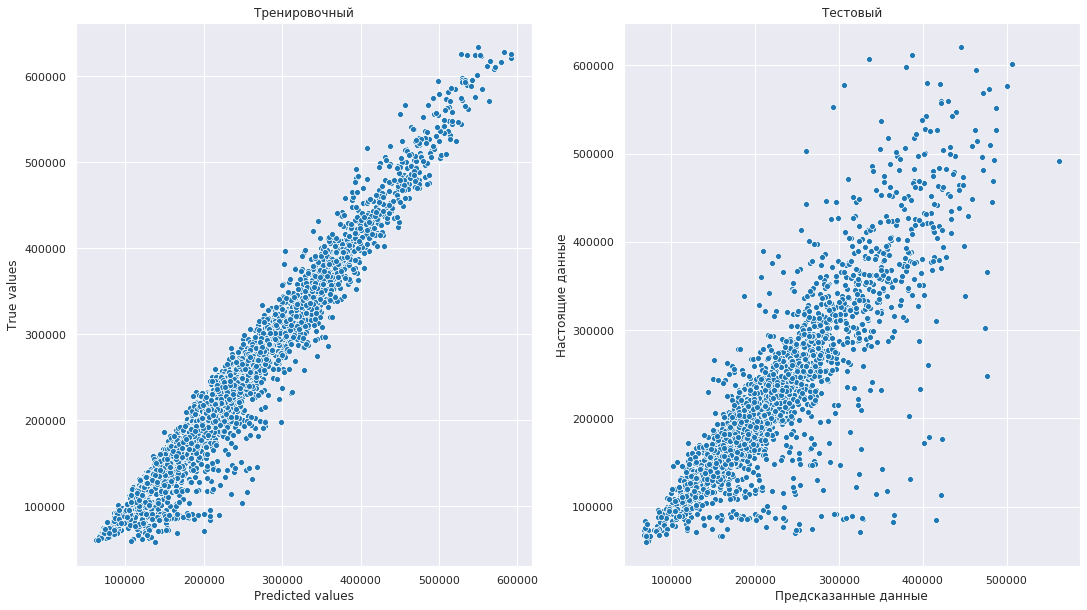

In [62]:
evaluate_preds(y_train, y_pred_train, y_valid, y_pred_valid)

### XGB

In [63]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, gamma=0.3, subsample=0.7,min_child_weight=4,
                           colsample_bytree=1, max_depth=7, objective ='reg:squarederror', nthread=-1, random_state=21)
xgb.fit(X_train, y_train)



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.3,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=4, missing=None, n_estimators=100,
             n_jobs=1, nthread=-1, objective='reg:squarederror',
             random_state=21, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.7, verbosity=1)

In [64]:
#params = {'min_child_weight':[4,5], 
        #  'gamma':[i/10.0 for i in range(3,6)],  
          #'subsample':[i/10.0 for i in range(6,11)],
         # 'max_depth': [2,3,4,7]}

#xgb = XGBRegressor(nthread=-1, objective ='reg:squarederror') 

#grid = GridSearchCV(xgb, params)
#grid.fit(X_train,y_train) 

In [65]:

y_pred_train_g = xgb.predict(X_train)
y_pred_valid_g = xgb.predict(X_valid)


r2(y_train, y_pred_train_g)

0.9063253579420364

In [66]:
r2(y_valid, y_pred_valid_g)

0.7757648118038951

Тренировочный R2:	0.906
Тестовый R2:	0.776


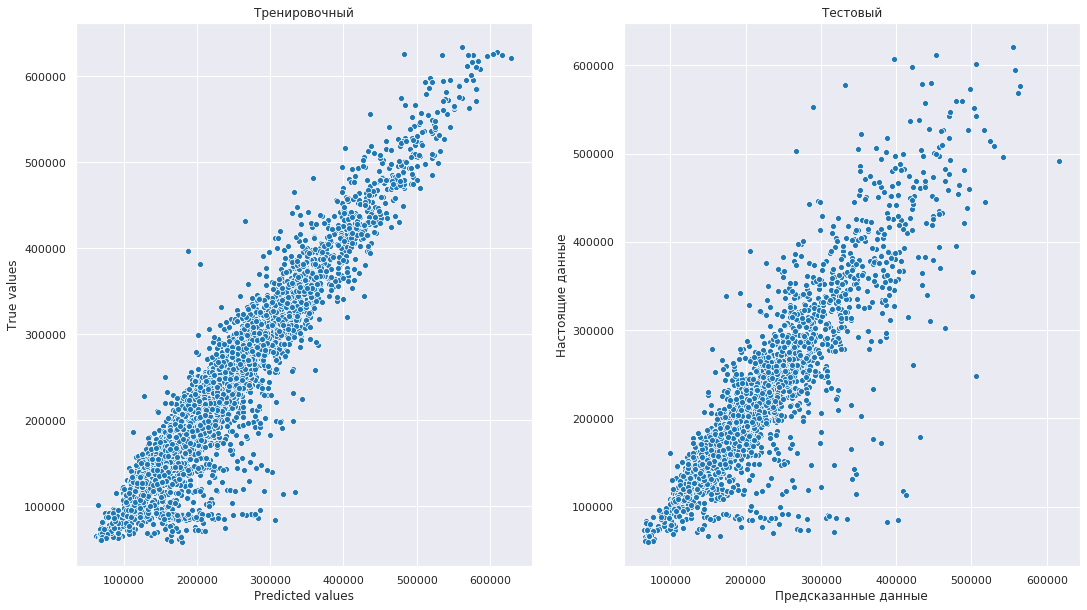

In [67]:
evaluate_preds(y_train, y_pred_train_g, y_valid, y_pred_valid_g)

### Кросс валидация моделей

In [68]:
#cv_score2 = cross_val_score(xgb, X, y, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=43))
#cv_score2.mean()

In [69]:
#cv_score3 = cross_val_score(model, X, y, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=21))
#cv_score3.mean()

In [70]:
test = test.reset_index('Id')

In [71]:
test["Price"] = model.predict(X_test)

In [72]:
test.loc[:, ['Id', 'Price']].to_csv('JaneCalm_predictionsLast.csv', index=False)

In [73]:
test["Price"] = xgb.predict(X_test)

In [74]:
test.loc[:, ['Id', 'Price']].to_csv('JaneCalm_predictionsLast2.csv', index=False)